# Handwriting recognition


## Data collection

In [ ]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

Preview how the dataset is organized. Lines prepended by "#" are just metadata information.

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


## Imports

In [ ]:

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from IPython.display import clear_output

from tensorflow import keras
from tensorflow.keras.layers import StringLookup
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/gdrive')

np.random.seed(42)
tf.random.set_seed(42)

Mounted at /gdrive


## Dataset splitting

In [ ]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


## Data input pipeline

We start building our data input pipeline by first preparing the image paths.

In [ ]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

Then we prepare the ground-truth labels.

labels with max length: middle-income-bracket
labels with max length: plate-and-corrugation
{'sure': 4, 'he': 2, 'during': 6, 'of': 2, 'booty': 5, 'gastronomy': 10, 'boy': 3, 'The': 3, 'and': 3, 'in': 2, 'his': 3, 'flying': 6, 'presented': 9, 'No': 2, 'as': 2, 'few': 3, 'work': 4, 'items': 5, 'took': 4, '"': 1, ':': 1, '.': 1, 'sedate': 6, 'over': 4, 'much': 4, 'compelled': 9, 'several': 7, 'a': 1, 'said': 4, 'families': 8, 'While': 5, 'at': 2, 'capital': 7, 'A': 1, 'get': 3, 'reasonably': 10, 'thought': 7, 'shack': 5, 'method': 6, 'was': 3, 'to': 2, 'killed': 6, 'stuff': 5, 'Tom': 3, 'Really': 6, 'civil': 5, "brother's": 9, 'any': 3, 'And': 3, 'I': 1, 'interference': 12, ',': 1, 'research': 8, 'crochet': 7, 'the': 3, 'enough': 6, 'her': 3, 'Powell': 6, 'are': 3, 'employing': 9, 'man': 3, 'perhaps': 7, 'death': 5, 'seem': 4, 'shares': 6, 'had': 3, 'something': 9, 'allowed': 7, 'anti-Tory': 9, 'nothing': 7, '!': 1, 'Both': 4, 'Bills': 5, 'she': 3, 'will': 4, "'": 1, 'Aubrey': 6, 'Draugh

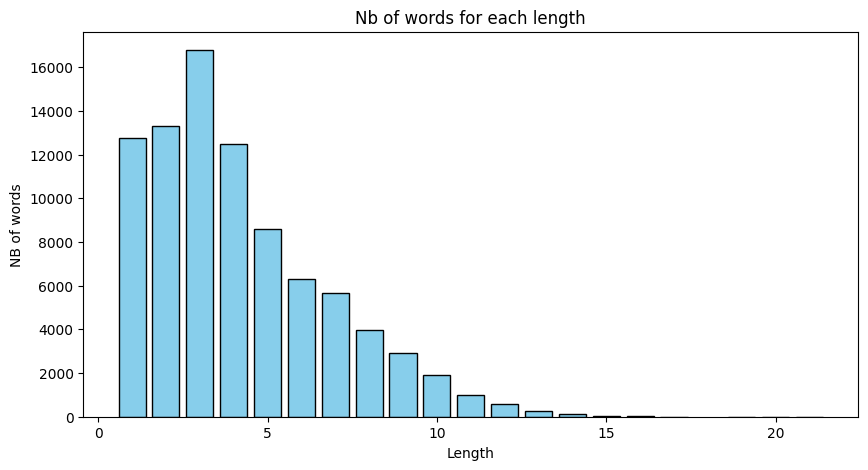

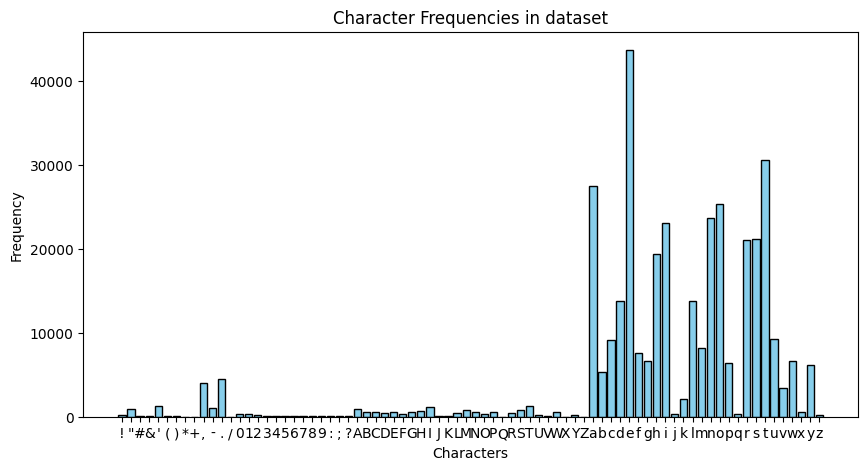

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0
length = {}
for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)
    length.update({label : len(label)})
    max_len = max(max_len, len(label))
    if len(label) == 21:
        print(f"labels with max length: {label}")
    train_labels_cleaned.append(label)
print(length)
characters = sorted(list(characters))
print(characters)
print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

char_counts = {char: 0 for char in characters}

# Iterate over each word and each character in each word
for word in train_labels_cleaned:
    for char in word:
        if char in char_counts:
            char_counts[char] += 1

# Filter out characters with zero counts to display only those that appear
non_zero_counts = {char: count for char, count in char_counts.items() if count > 0}

length_count = {}

# Count each word's length
for word in train_labels_cleaned:
    length = len(word)  # Get the length of the word
    if length in length_count:
        length_count[length] += 1  # Increment count if length already in dictionary
    else:
        length_count[length] = 1  # Initialize count if length not in dictionary yet

print(f"nb of words in each length: {length_count}")
print(f"Character appearance: {non_zero_counts}")

# Check some label samples.
train_labels_cleaned[:10]

plt.figure(figsize=(10, 5))  # Set figure size
plt.bar(length_count.keys(), length_count.values() , color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Nb of words for each length')
plt.xlabel('Length')
plt.ylabel('NB of words')

# Show the plot
plt.show()


plt.figure(figsize=(10, 5))  # Set figure size
plt.bar(non_zero_counts.keys(), non_zero_counts.values(), color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Character Frequencies in dataset')
plt.xlabel('Characters')
plt.ylabel('Frequency')

# Show the plot
plt.show()

Now we clean the validation and the test labels as well.

In [ ]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### Building the character vocabulary

Keras provides different preprocessing layers to deal with different modalities of data.
[This guide](https://keras.io/api/layers/preprocessing_layers/) provides a comprehensive introduction.
Our example involves preprocessing labels at the character
level. This means that if there are two labels, e.g. "cat" and "dog", then our character
vocabulary should be {a, c, d, g, o, t} (without any special tokens). We use the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/)
layer for this purpose.

In [ ]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

### Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become
clearer in a moment when we will visualize a few samples from the dataset. While
aspect-unaware resizing square images does not introduce a significant amount of
distortion this is not the case for rectangular images. But resizing images to a uniform
size is a requirement for mini-batching. So we need to perform our resizing such that
the following criteria are met:

* Aspect ratio is preserved.
* Content of the images is not affected.

In [ ]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


### Putting the utilities together

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


## Prepare `tf.data.Dataset` objects

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

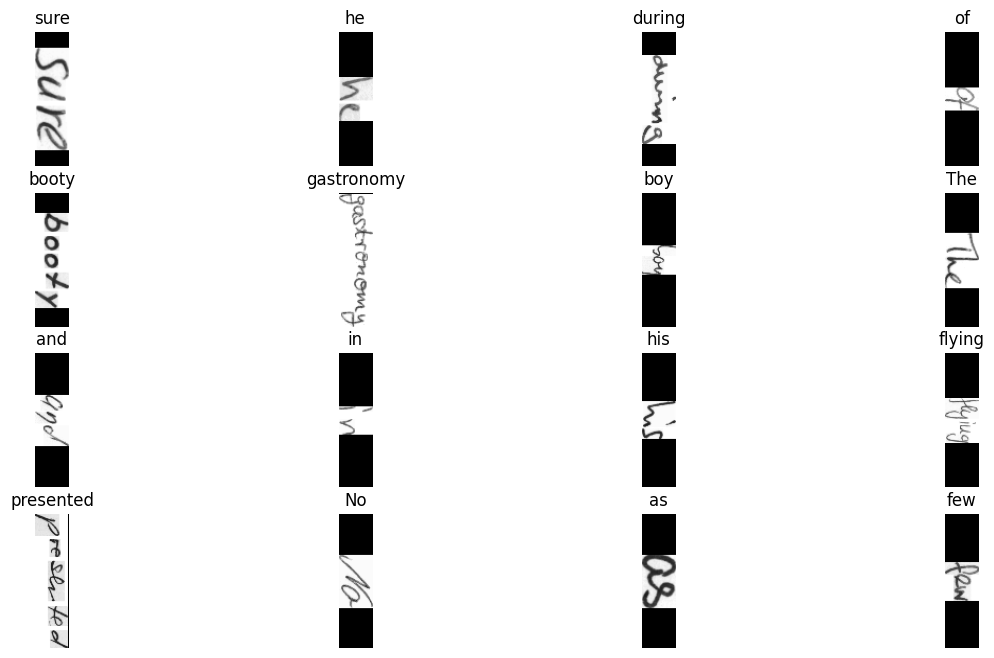

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        augmented_image = data_augmentation(img)
        augmented_image = tf.transpose(augmented_image, perm=[1, 0, 2])
        augmented_image = (augmented_image * 255.0).numpy().clip(0, 255).astype(np.uint8)
        augmented_image = augmented_image[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
          # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

## Visualize a few samples

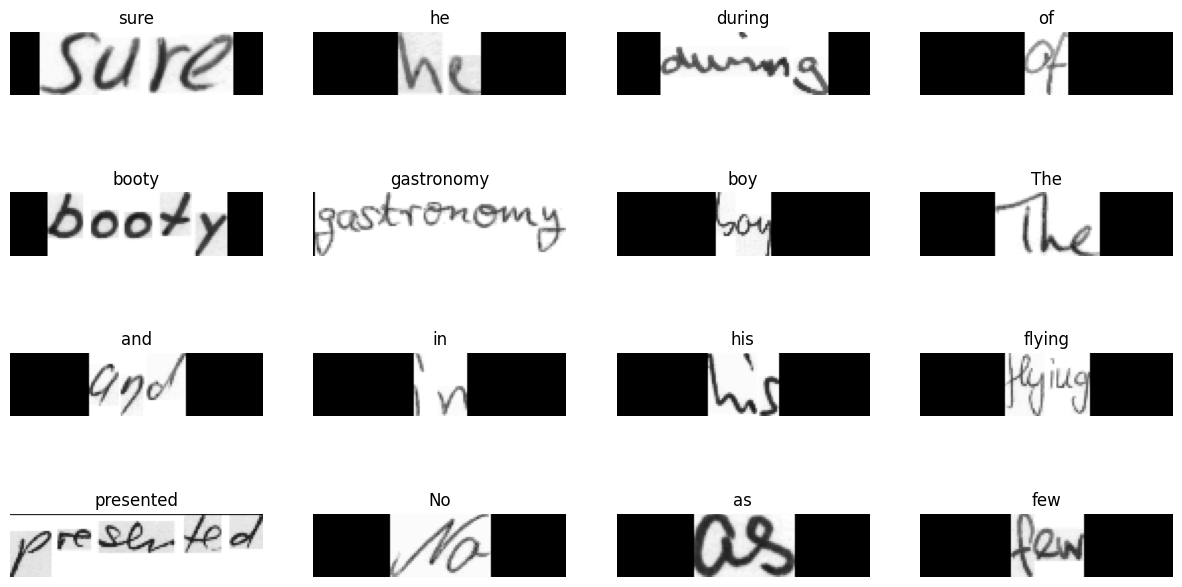

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

You will notice that the content of original image is kept as faithful as possible and has
been padded accordingly.

## Model

Our model will use the CTC loss as an endpoint layer. For a detailed understanding of the
CTC loss, refer to [this post](https://distill.pub/2017/ctc/).

In [ ]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model

    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

## Evaluation metric

[Edit Distance](https://en.wikipedia.org/wiki/Edit_distance)
is the most widely used metric for evaluating OCR models. In this section, we will
implement it and use it as a callback to monitor our model.

We first segregate the validation images and their labels for convenience.

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

Now, we create a callback to monitor the edit distances.

In [ ]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [ ]:
class LivePlotCallback(Callback):
    def __init__(self, figsize=(7, 5)):
        super(LivePlotCallback, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs=None):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        plt.ion()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        plt.plot(self.epochs, self.losses, label='Training Loss')
        if self.val_losses[-1] is not None:
            plt.plot(self.epochs, self.val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## Training

Now we are ready to kick off model training.

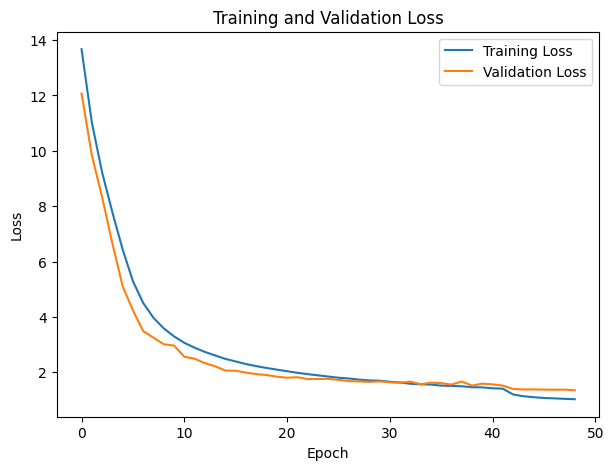


Epoch 49: val_loss improved from 1.37327 to 1.35387, saving model to /gdrive/MyDrive/FYP/myModel.keras
1357/1357 [==============================] - 92s 68ms/step - loss: 1.0307 - val_loss: 1.3539 - lr: 2.0000e-04


In [ ]:
epochs = 49  

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)
live_plot = LivePlotCallback()
mcp_save = ModelCheckpoint('/gdrive/MyDrive/FYP/myModel.keras', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')
RLP = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)
# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback, live_plot, mcp_save, RLP, keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])


In [ ]:
print(history.history)
print(history.epoch)

{'loss': [13.669246673583984, 11.02556037902832, 9.221458435058594, 7.780505657196045, 6.438059329986572, 5.292736530303955, 4.503862380981445, 3.9700305461883545, 3.5904219150543213, 3.2986867427825928, 3.068263053894043, 2.8914852142333984, 2.7392475605010986, 2.6110639572143555, 2.487262725830078, 2.3954408168792725, 2.300668478012085, 2.226952314376831, 2.1590893268585205, 2.099801778793335, 2.042356491088867, 1.984760046005249, 1.9370161294937134, 1.8932148218154907, 1.8496057987213135, 1.8067407608032227, 1.7798916101455688, 1.7389079332351685, 1.7088794708251953, 1.7015620470046997, 1.6597586870193481, 1.636305809020996, 1.5884369611740112, 1.5712342262268066, 1.5586504936218262, 1.5218602418899536, 1.510452151298523, 1.497982144355774, 1.464544653892517, 1.4583179950714111, 1.4251714944839478, 1.4109843969345093, 1.2016324996948242, 1.1381386518478394, 1.1045230627059937, 1.075074315071106, 1.061217188835144, 1.0446697473526, 1.0306557416915894], 'val_loss': [12.0689058303833, 

## Inference

2/2 [==============================] - 0s 16ms/step


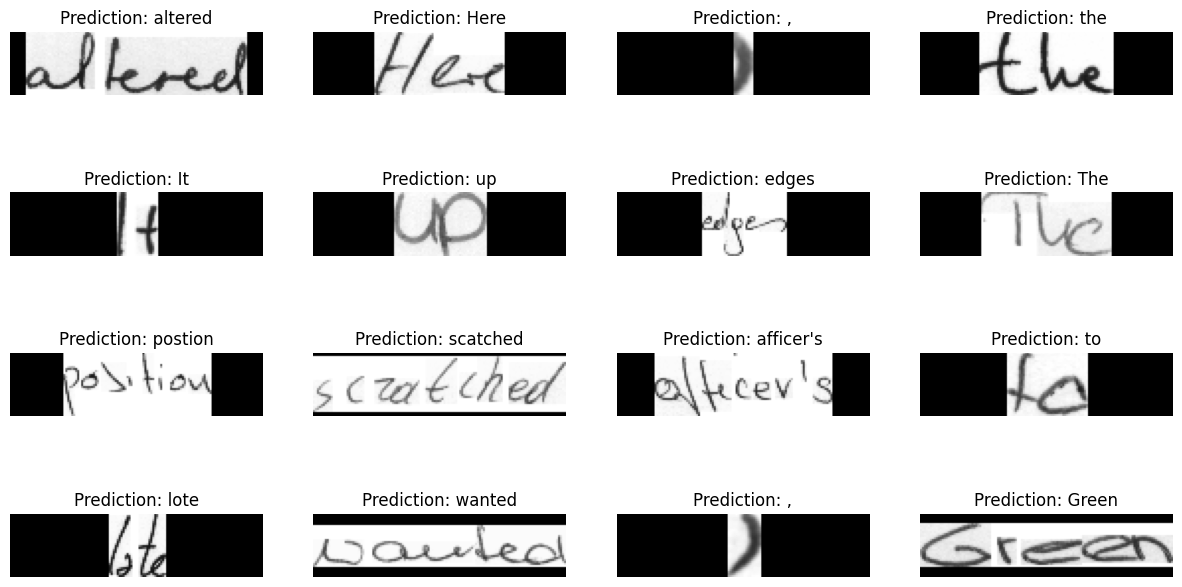

In [ ]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
model.save('/gdrive/MyDrive/FYP/model.keras')

In [ ]:
import tensorflow as tf
from tensorflow import keras

@tf.keras.utils.register_keras_serializable()
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


    def get_config(self):
        return super().get_config()

# Now, you can safely load the model
new_model = tf.keras.models.load_model('/gdrive/MyDrive/FYP/model.keras', custom_objects={'CTCLayer': CTCLayer}, safe_mode=False)

In [ ]:
new_model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
for batch in test_ds.take(1):

    batch_images = batch["image"]
    batch_labels = batch["label"]
    prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
    )

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    orig_texts = []
    for label in batch_labels:
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        orig_texts.append(label)

print(precision_score(orig_texts, pred_texts, average='macro'))
print(recall_score(orig_texts, pred_texts, average='macro'))
print(f1_score(orig_texts, pred_texts, average='macro'))
print(accuracy_score(orig_texts, pred_texts))

2/2 [==============================] - 2s 14ms/step
0.6231343283582089
0.6268656716417911
0.6247334754797442
0.796875


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
new_model.evaluate(test_ds)

76/76 [==============================] - 9s 74ms/step - loss: 1.3813


1.3812637329101562